In [1]:
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as ss ## stat functions from scipy
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [2]:
def extract_data(path, adata):
    loom = sc.read( path, validate=False)
    tmp = pd.DataFrame(loom.X.toarray())
    tmp.columns = loom.var_names.to_list()
    tmp.index = loom.obs_names.to_list()
    adata = sc.read(adata)
    adata = adata[adata.obs.new_label != "Others"]
    labels = pd.Series(adata.obs.new_label)

    exh = pd.DataFrame(columns=tmp.columns)
    res = pd.DataFrame(columns=tmp.columns)

    for i,c in labels.items():
        if c == "NK exhausted":
            try:
                exh = exh.append(pd.DataFrame(tmp.loc[i]).T)
            except:
                pass
        elif c == "NK resident":
            try:
                res = res.append(pd.DataFrame(tmp.loc[i]).T)
            except:
                pass
        else:
            continue
    return exh, res


In [3]:
ht_exh, ht_res = extract_data("Results/75/ht_scenic_integrated-output.loom", "Data/75/heathy_nk_processed.h5ad")
mm_exh, mm_res = extract_data("Results/75/mm_scenic_integrated-output.loom", "Data/75/mm_nk_processed.h5ad")

In [4]:
# ht_res = extract_data("Results/ht_res_scenic_integrated-output.loom")
# ht_exh = extract_data("Results/ht_exh_scenic_integrated-output.loom")
# mm_res = extract_data("Results/mm_res_scenic_integrated-output.loom")
# mm_exh = extract_data("Results/mm_exh_scenic_integrated-output.loom")

dfs = {"ht_res": ht_res, "ht_exh":ht_exh,"mm_res":mm_res,"mm_exh":mm_exh}

In [5]:

def plot_mean_auc(TF):
    means = {}

    for k,v in dfs.items():
        try:
            means[k] = v[TF].mean()
        except:
            #print(f"{TF} missing in {k}")
            pass
    
    means_df = pd.DataFrame(means, index=[0])
    try:
        means_df.plot.bar()
        plt.title(TF + " avg activity")
    except:
        pass
    
def get_values(df, TF):
    tmp = pd.DataFrame(dfs[df][TF])
    tmp = tmp[TF].values
    tmp = tmp[tmp!=0]
    return tmp



def stat(df1, df2, TF):
    pair = (df1,df2)
    try:
        value1 = get_values(df1, TF)
        value2 = get_values(df2, TF)
    except:
        d = {'TF': [TF], df1: "missing value", df2: "",'p-value':"", 'test': ""}
        df = pd.DataFrame.from_dict(data=d, orient="columns")
        return df

    
         
    if ((ss.normaltest(value1)[1] > 0.05 and ss.normaltest(value2)[1] > 0.05) and (ss.bartlett(value2,value1)[1] > 0.05)):
        test = 't-test_ind'
        pvalue = ss.ttest_ind(value1, value2, nan_policy="omit", equal_var=True).pvalue 
        



    elif ((ss.normaltest(value1)[1] > 0.05 and ss.normaltest(value2)[1] > 0.05) and (ss.bartlett(value2,value1)[1] < 0.05)):
        test = 't-test_welch'
        pvalue = ss.ttest_ind(value1, value2, nan_policy="omit", equal_var=False).pvalue 
        


    else:
        test = 'Kruskal-Wallis'
        pvalue = ss.kruskal(value1, value2, nan_policy="omit").pvalue 


        
    if pvalue <= 1.00e-04:
        stars = '****'
    elif pvalue > 1.00e-04 and pvalue <= 1.00e-03:
        stars = '***'
    elif pvalue > 1.00e-03 and pvalue <= 1.00e-02:
        stars = '**'
    elif pvalue > 1.00e-02 and pvalue <= 5.00e-02:
        stars = '*'
    else:
        stars = 'np'
    d = {'TF': [TF], df1: [np.mean(value1)], df2: [np.mean(value2)],'p-value':[stars], 'test': [test]}
    df = pd.DataFrame.from_dict(data=d, orient="columns")

    return df

In [6]:
TFs=["MYC","BACH2","PRDM1","SPI1","SREBF1","STAT4","RUNX2","ZEB2","ZBTB32","EOMES","TBX21","NR3C1"]

## Differences exhausted resident in MM:

In [7]:
df = pd.DataFrame()

for TF in TFs:
    df = df.append(stat("mm_exh","mm_res", TF))

df.sort_values(by="p-value", ascending=False)

,TF,mm_exh,mm_res,p-value,test
0,MYC,1.095238,2.310811,np,Kruskal-Wallis
0,BACH2,1.096774,1.341177,np,Kruskal-Wallis
0,PRDM1,1.900654,2.086539,np,Kruskal-Wallis
0,STAT4,1.528846,1.556114,np,Kruskal-Wallis
0,EOMES,1.477778,1.456193,np,Kruskal-Wallis
0,TBX21,1.384984,1.446985,np,Kruskal-Wallis
0,NR3C1,2.011086,2.375963,**,Kruskal-Wallis
0,ZEB2,3.292345,3.465479,*,Kruskal-Wallis
0,SPI1,missing value,,,
0,SREBF1,missing value,,,


## Differences exhausted resident in healthy:

In [8]:
df = pd.DataFrame()

for TF in TFs:
    df = df.append(stat("ht_exh","ht_res", TF))

df.sort_values(by="p-value", ascending=False)

,TF,ht_exh,ht_res,p-value,test
0,PRDM1,1.125,1.08046,np,Kruskal-Wallis
0,STAT4,1.153846,1.139535,np,Kruskal-Wallis
0,EOMES,1.0,1.121622,np,Kruskal-Wallis
0,TBX21,1.0,1.152838,np,Kruskal-Wallis
0,NR3C1,1.0,1.08,np,Kruskal-Wallis
0,ZEB2,1.47619,1.289827,*,Kruskal-Wallis
0,MYC,missing value,,,
0,BACH2,missing value,,,
0,SPI1,missing value,,,
0,SREBF1,missing value,,,


## Differences exhausted MM vs healthy:

In [9]:
df = pd.DataFrame()

for TF in TFs:
    df = df.append(stat("mm_exh","ht_exh", TF))

df.sort_values(by="p-value", ascending=False)

,TF,mm_exh,ht_exh,p-value,test
0,STAT4,1.528846,1.153846,np,Kruskal-Wallis
0,EOMES,1.477778,1.0,np,Kruskal-Wallis
0,ZEB2,3.292345,1.47619,****,Kruskal-Wallis
0,NR3C1,2.011086,1.0,**,Kruskal-Wallis
0,PRDM1,1.900654,1.125,*,Kruskal-Wallis
0,TBX21,1.384984,1.0,*,Kruskal-Wallis
0,MYC,missing value,,,
0,BACH2,missing value,,,
0,SPI1,missing value,,,
0,SREBF1,missing value,,,


## Differences resident MM vs healthy:

In [10]:
df = pd.DataFrame()

for TF in TFs:
    df = df.append(stat("mm_res","ht_res", TF))

df.sort_values(by="p-value", ascending=False)

,TF,mm_res,ht_res,p-value,test
0,PRDM1,2.086539,1.08046,****,Kruskal-Wallis
0,STAT4,1.556114,1.139535,****,Kruskal-Wallis
0,ZEB2,3.465479,1.289827,****,Kruskal-Wallis
0,TBX21,1.446985,1.152838,****,Kruskal-Wallis
0,NR3C1,2.375963,1.08,****,Kruskal-Wallis
0,EOMES,1.456193,1.121622,***,Kruskal-Wallis
0,MYC,missing value,,,
0,BACH2,missing value,,,
0,SPI1,missing value,,,
0,SREBF1,missing value,,,


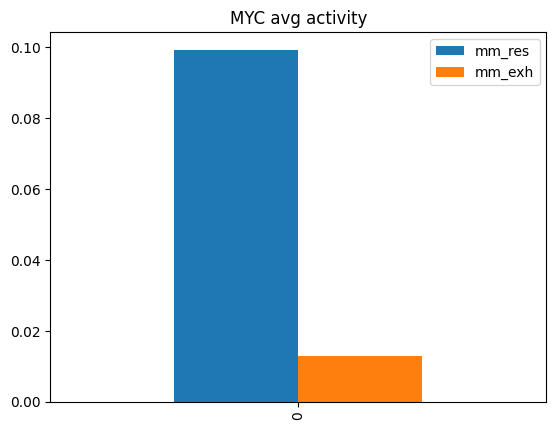

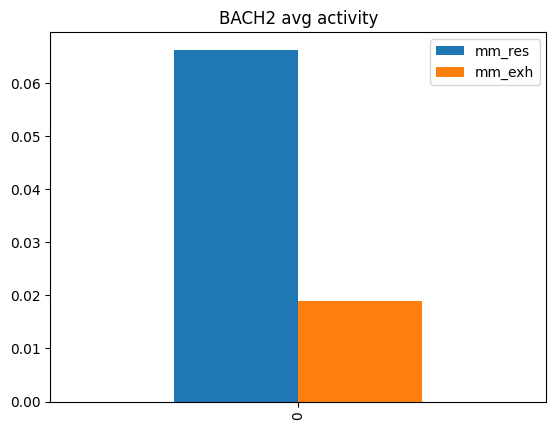

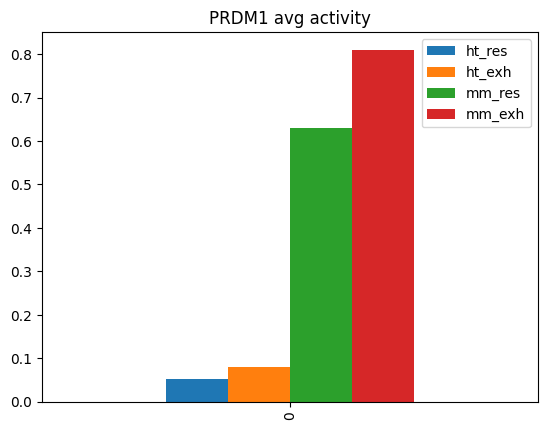

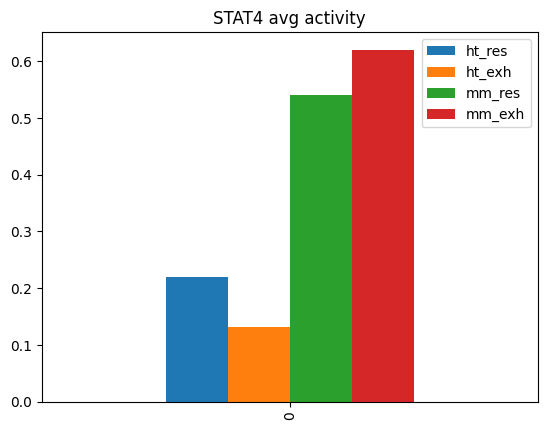

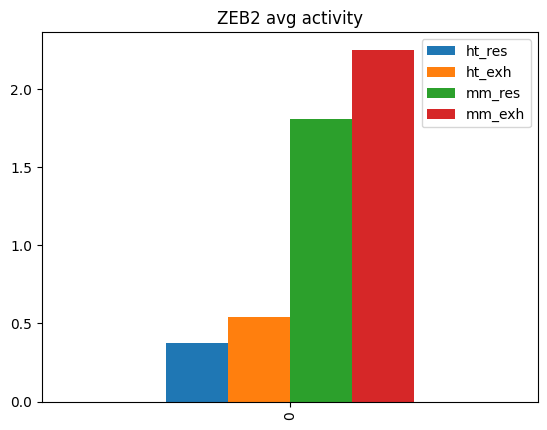

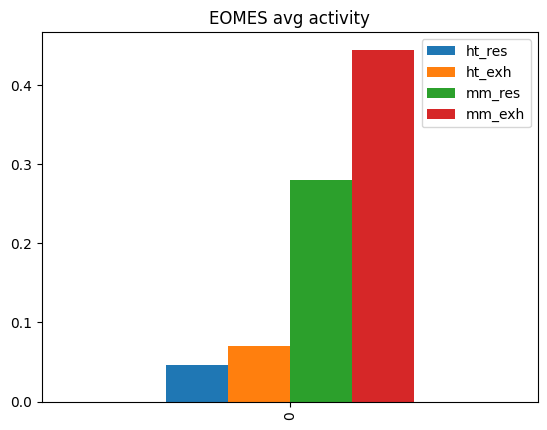

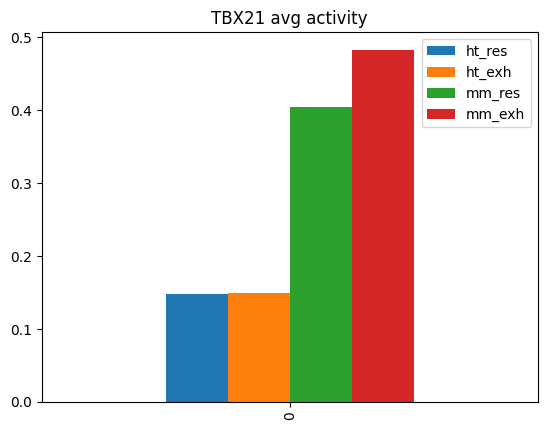

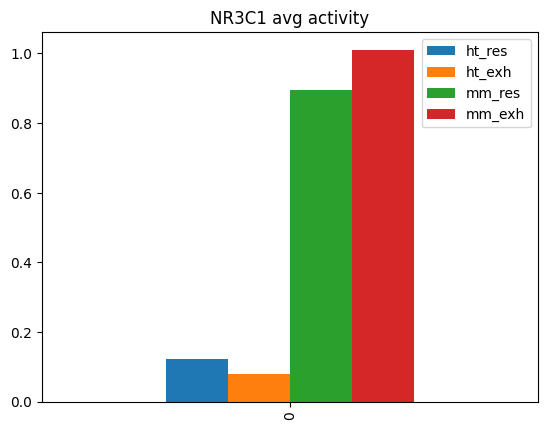

In [11]:
for TF in TFs:
    plot_mean_auc(TF)